In [ ]:
# DSP 461: Final Project
# Carly Carroll and Ryan Tsang

In [13]:
##### LOAD LIBRARIES #####

import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_absolute_error, r2_score
import os
#from google.colab import files
import joblib

In [ ]:
##### DATA UPLOADING AND PREPROCESSING #####

# get the data from the github repository
url = "https://raw.githubusercontent.com/carlycarroll25/DSP461_FinalProject/refs/heads/main/Data/affordability.csv"

#load in affordability data
affordability = pd.read_csv(url)

# drop the states and regions; we only need the numbers to help train the model
# affordability.drop_duplicates(subset=['RegionName', 'StateName'], inplace=True)
    # I wanted more data, so I didn't drop the duplicates
print(affordability.shape)

(3813, 56)


In [82]:
### feature engineering and scaling ###

# define regression features and target
regression_features = [
    "HousingCostAvg", "TotalLivingCost", "median_family_income",
    "TotalPop", "crime_rate_per_100000"
]
X_reg = affordability[regression_features]
y_reg = affordability["AffordabilityScore"]

#Find the min and max of each feature in X_reg
min_max = {}
for feature in regression_features:
    min_max[feature] = (X_reg[feature].min(), X_reg[feature].max())
print(min_max)

# define classification features and target
classification_features = [
    "INflow", "OUTflow", "TotalPop", "HousingCostAvg", "median_family_income"
]
X_class = affordability[classification_features]
if "MigrationClass" not in affordability.columns:
    affordability["MigrationClass"] = pd.cut(
        affordability["NET in"], bins=[-float('inf'), -1, 1, float('inf')],
        labels=["Net Loss", "Neutral", "Net Gain"]
    )
y_class = affordability["MigrationClass"]

## scale features
scaler = StandardScaler()
X_reg_scaled = scaler.fit_transform(X_reg)
X_class_scaled = scaler.fit_transform(X_class)

## split the data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_scaled, y_reg, test_size=0.3, random_state=42
)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class_scaled, y_class, test_size=0.3, random_state=42
)

# separate scalers for affordability and migration
scaler_affordability = StandardScaler()
scaler_migration = StandardScaler()

# fit scalers on respective datasets
X_affordability = affordability[["HousingCostAvg", "TotalLivingCost", "median_family_income", "TotalPop", "crime_rate_per_100000"]]
X_migration = affordability[["INflow", "OUTflow", "TotalPop", "HousingCostAvg", "median_family_income"]]

scaler_affordability.fit(X_affordability)
scaler_migration.fit(X_migration)

{'HousingCostAvg': (31381.361503421907, 1176416.546959951), 'TotalLivingCost': (54431.025324, 167022.47467199998), 'median_family_income': (45283.02734375, 165123.890625), 'TotalPop': (9257.0, 10105722.0), 'crime_rate_per_100000': (21.43737607, 1150.29633)}


StandardScaler()

In [78]:
### model training ###

# train regression model
regressor = RandomForestRegressor(random_state=42, n_estimators=100)
regressor.fit(X_train_reg, y_train_reg)

# train classification model
classifier = RandomForestClassifier(random_state=42, n_estimators=100)
classifier.fit(X_train_class, y_train_class)

RandomForestClassifier(random_state=42)

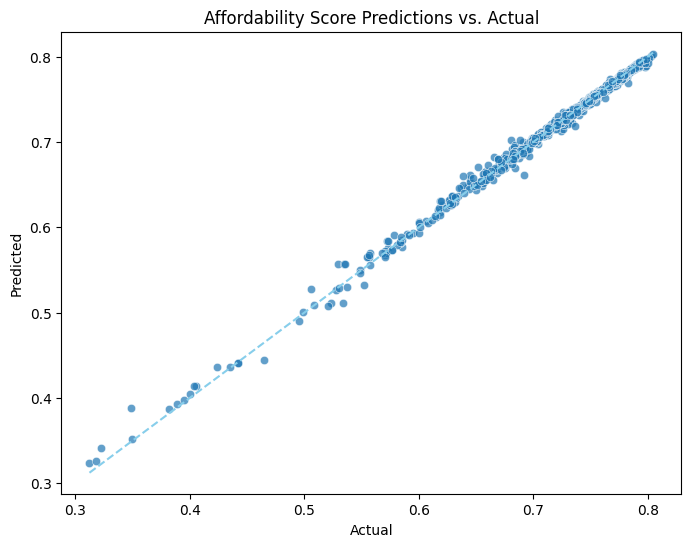

In [79]:
### Verify model accuracy ###
def plot_predictions(y_test, y_pred, target_name):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='skyblue', linestyle='--')
    plt.title(f"{target_name} Predictions vs. Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

# predict on test set
y_pred_reg = regressor.predict(X_test_reg)
plot_predictions(y_test_reg, y_pred_reg, "Affordability Score")

In [86]:
### prediction functions ###

# affordability prediction function
def predict_affordability(HousingCostAvg, TotalLivingCost, median_family_income, TotalPop, crime_rate_per_100000):
    features = pd.DataFrame(
        [[HousingCostAvg, TotalLivingCost, median_family_income, TotalPop, crime_rate_per_100000]],
        columns=["HousingCostAvg", "TotalLivingCost", "median_family_income", "TotalPop", "crime_rate_per_100000"]
    )
    # scale the features
    scaled_features = scaler_affordability.transform(features)
    prediction = regressor.predict(scaled_features)
    return f"Predicted Affordability Score: {prediction[0]:.2f}"

# migration classification function
def classify_migration(INflow, OUTflow, TotalPop, HousingCostAvg, median_family_income):
    features = pd.DataFrame(
        [[INflow, OUTflow, TotalPop, HousingCostAvg, median_family_income]],
        columns=["INflow", "OUTflow", "TotalPop", "HousingCostAvg", "median_family_income"]
    )
    scaled_features = scaler_migration.transform(features)
    prediction = classifier.predict(scaled_features)
    return f"Predicted Migration Class: {prediction[0]}"

In [ ]:
### run gradio script ###

# create the gradio interface
demo = gr.Interface(fn=predict_affordability, 
                    # Inputs are within the min and max of the training data
                    inputs=[gr.Slider(30000,125000), gr.Slider(50000,175000),gr.Slider(45000,175000),gr.Slider(9000,10000000),gr.Slider(20,1200)], 
                    outputs="text")
demo.launch()

* Running on local URL:  http://127.0.0.1:7873

To create a public link, set `share=True` in `launch()`.
